In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 32s 411ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150 - val_loss: 0.1467 - val_root_mean_squared_error: 0.3830
Epoch 2/50
53/53 [==============================] - 25s 477ms/step - loss: 0.0937 - root_mean_squared_error: 0.3061 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2545
Epoch 3/50
53/53 [==============================] - 25s 482ms/step - loss: 0.0584 - root_mean_squared_error: 0.2417 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2129
Epoch 4/50
53/53 [==============================] - 26s 501ms/step - loss: 0.0370 - root_mean_squared_error: 0.1923 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 5/50
53/53 [==============================] - 26s 499ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 6/50
53/53 [==============================] - 4s 69ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0128 - 

Epoch 33/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 34/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 35/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 36/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0729
Epoch 37/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 38/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0040 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.562177689870198 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

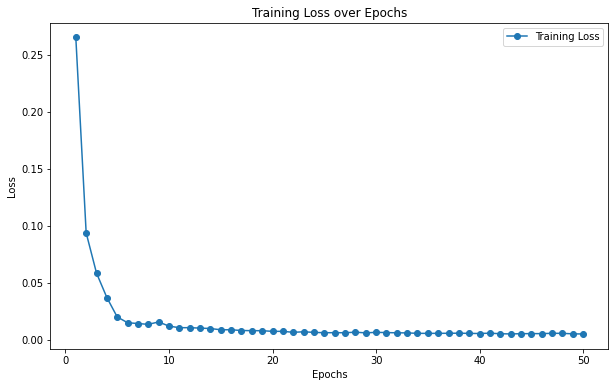

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

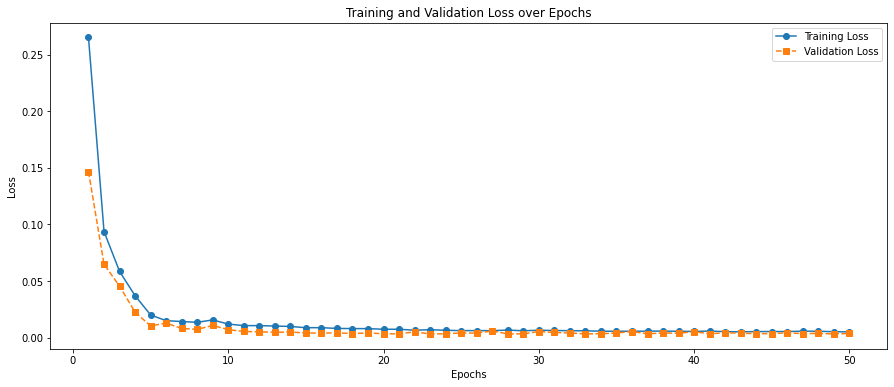

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 39ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06234115963639307
MAE : 0.051571877410254936


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.844935e+06,6574288.749
1,6.113736e+06,6669726.076
2,5.843424e+06,6516136.854
3,5.031394e+06,5902163.675
4,3.641586e+06,3498103.449
5,1.629939e+06,1633675.726
6,8.625449e+05,1292668.399
7,1.074880e+06,1527666.815
8,1.915234e+06,2121949.701
9,3.180456e+06,3562381.775


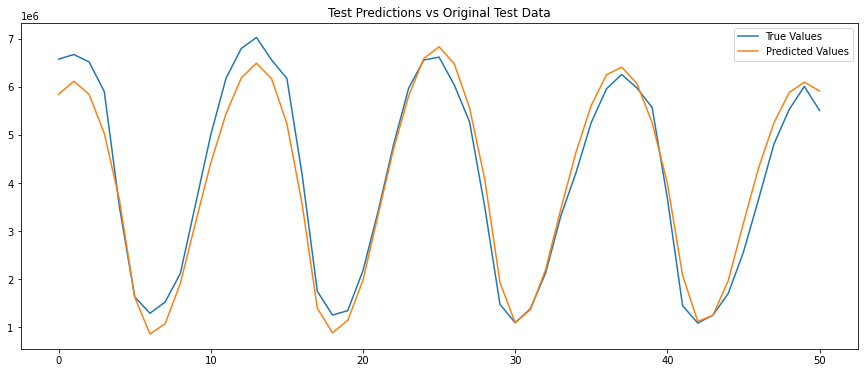

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 38ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

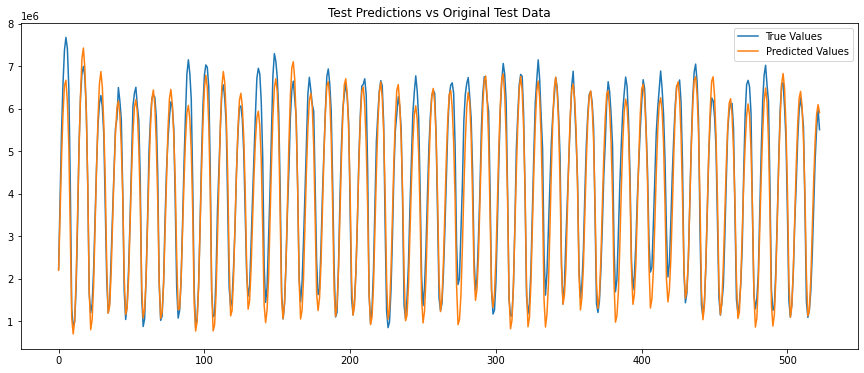

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()